## 모듈 불러오기

In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import glob
import tensorflow as tf
import cv2
from PIL import Image
from tqdm import tqdm

## 이미지를 불러오기 위한 준비

In [2]:
filenames = os.listdir("D:/cat&dog")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [3]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [4]:
df.info() # 데이터셋의 정보를 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  50000 non-null  object
 1   category  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [5]:
df['category'].value_counts() # 분류하고자하는 클래스의 비율을 확인

0    25000
1    25000
Name: category, dtype: int64

<Axes: >

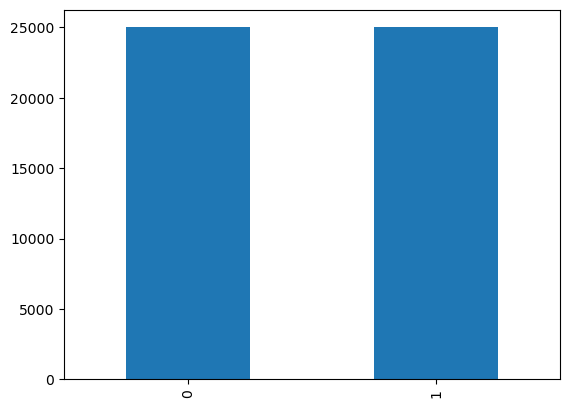

In [6]:
df['category'].value_counts().plot.bar() # 시각화를 통해 확인

In [7]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

## 이미지 파일의 크기가 달라서 같은 크기 및 비율로 맞춰주기

In [ ]:
input_path = 'D:/cat&dog/*.jpg'
file_list = [file for file in glob.glob(input_path)]


img_resize_list = []
for f in tqdm(file_list):
    img = Image.open(f)
    img_resize = img.resize((256, 256))
    img_resize_list.append(img_resize.size)
    
    title, ext = os.path.splitext(f)
    img_resize.save(title + '_resize' + ext)

# feature와 label 추출하기

In [14]:
paths = glob.glob('D:/cat&dog/*_resize.jpg')
paths = np.random.permutation(paths)
paths[0]
features = np.array([plt.imread(paths[i]) for i in tqdm(range(len(paths)))])
label = np.array([paths[i].split('\\')[1].split('.')[0] for i in tqdm(range(len(paths)))])
print(features.shape, label.shape)

100%|████████████████████████████████████████████████████████████████████████| 25000/25000 [00:00<00:00, 183525.39it/s]


(25000, 256, 256, 3) (25000,)


In [24]:
label = pd.get_dummies(label)
print(features.shape, label.shape)

(25000, 256, 256, 3) (25000, 2)


# 모델 만들기

In [30]:
X = tf.keras.layers.Input(shape = [256, 256, 3])

H = tf.keras.layers.Conv2D(6, kernel_size = 5, activation = 'swish')(X)
H = tf.keras.layers.MaxPool2D()(H)

H = tf.keras.layers.Conv2D(6, kernel_size = 5, activation = 'swish')(H)
H = tf.keras.layers.MaxPool2D()(H)

H = tf.keras.layers.Flatten()(H)
H = tf.keras.layers.Dense(120, activation = 'swish')(H)
H = tf.keras.layers.Dense(84, activation = 'swish')(H)
Y = tf.keras.layers.Dense(2, activation = 'softmax')(H)

model = tf.keras.models.Model(X, Y)
model.compile(loss = 'categorical_crossentropy', metrics = 'accuracy')

In [31]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 252, 252, 6)       456       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 126, 126, 6)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 122, 122, 6)       906       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 61, 61, 6)        0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 22326)             0   

# 모델 학습하기

In [32]:
model.fit(features, label, epochs = 10)

Epoch 1/10
782/782 [==============================] - 579s 740ms/step - loss: 5.4912 - accuracy: 0.5067
Epoch 2/10
782/782 [==============================] - 573s 733ms/step - loss: 0.7196 - accuracy: 0.5318
Epoch 3/10
782/782 [==============================] - 575s 735ms/step - loss: 0.7719 - accuracy: 0.5835
Epoch 4/10
782/782 [==============================] - 581s 743ms/step - loss: 0.7054 - accuracy: 0.6142
Epoch 5/10
782/782 [==============================] - 573s 733ms/step - loss: 0.6777 - accuracy: 0.6635
Epoch 6/10
782/782 [==============================] - 573s 733ms/step - loss: 0.5380 - accuracy: 0.7118
Epoch 7/10
782/782 [==============================] - 570s 729ms/step - loss: 0.4566 - accuracy: 0.7620
Epoch 8/10
782/782 [==============================] - 570s 729ms/step - loss: 0.5643 - accuracy: 0.8046
Epoch 9/10
782/782 [==============================] - 604s 773ms/step - loss: 0.3194 - accuracy: 0.8483
Epoch 10/10
782/782 [==============================] - 581s 743m

# 모델로 예측 결과 확인하기

In [33]:
pred = model.predict(features[0:5])
pd.DataFrame(pred).round(2)

1/1 [==============================] - 1s 1s/step


,0,1
0,0.84,0.16
1,1.00,0.00
2,0.14,0.86
3,0.62,0.38
4,1.00,0.00


In [34]:
label[0:5]

,cat,dog
0,1,0
1,1,0
2,0,1
3,1,0
4,1,0


In [40]:
# import tensorflow_datasets as tfds

# (raw_train, raw_validation, raw_test), metadata = tfds.load(
#     'cats_vs_dogs',
#     split=['train[:80%]','train[80%:90%]','train[90%:]'],
#     with_info=True,
#     as_supervised=True
# )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\chlwn\tensorflow_datasets\cats_vs_dogs\4.0.0.incompleteY0MKZF\cats_vs_dogs-train.tfrecord*.…

Dataset cats_vs_dogs downloaded and prepared to C:\Users\chlwn\tensorflow_datasets\cats_vs_dogs\4.0.0. Subsequent calls will reuse this data.


# 모델 저장하기

In [50]:
model.save('my_model.h5')

# 모델 불러오기

In [52]:
from tensorflow import keras

new_model = keras.models.load_model('my_model.h5')
# Show the model architecture
new_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 252, 252, 6)       456       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 126, 126, 6)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 122, 122, 6)       906       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 61, 61, 6)        0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 22326)             0   